# Using multiple threads to parallelise linear algebra operations

*Parallelising workflows and code can be hard.  However, there are easy wins to be found in using Python code to interact with mature, multi-threaded compiled software libraries that can make good use of the multiple CPU cores in modern machines.*

## Learning outcomes

* Can parallelise linear algebra and fast Fourier transform operations using python packages and multithreaded compiled software libraries. 
* Can control the degree of parallelisation. 
* Able to explain some of the issues that might impact on how the runtimes of multi-threaded functions scale with the number of available CPU cores
* Can explain why hyperthreading is problematic for parallel numerical computations.

## Setup if using JupyterHub on ShARC

Pre-requisites if you want to run through this tutorial using the [JupyterHub service on the University of Sheffield's ShARC cluster][sharc-jh]. 

1.  [Connect][sharc-jh-conn-res-req-start] to JupyterHub on ShARC
1.  Request computational resources (CPUs, RAM etc) for a [new Jupyter session  on ShARC][sharc-jh-conn-res-req-start].  
    * **Project**: leave as the default unless you are participating in a workshop and your instructor tells you differently.
    * **Job Queue**: leave as `any` unless you are participating in a workshop and your instructor tells you differently.
    * **CPU cores**: `4`
    * **Parallel Environment**: `smp` (you want all requested CPU cores to be allocated on one node)
    * **RAM per CPU core**: `1` (GB)
    * **GPUS per CPU core**: 0
    * **Notebook session runtime**: currently fixed at four hours. 
1.  [Start][sharc-jh-conn-res-req-start] your Jupyter session
1. Ensure these tutorial Notebooks exist in your `/home` (`~`) (or `/data`) directory on ShARC (if that's not the case already).  Open a [Jupyter Terminal][sharc-jh-term] and run:

    ```sh
    cd ~  
    git clone git://github.com/RSE-Sheffield/hi-perf-ipynb/
    ```
    
    Leave this Jupyter Terminal open.
1.  For this tutorial we want to create a [conda environment][sharc-jh-conda] containing the packages we are going to use in this tutorial.
    1.  (From your Jupyter Terminal) tell Conda to download and install packages from a new package repository 
        in addition to the default package repository:

        ```sh
        conda config --append channels conda-forge
        ```
    
    1.  Create a new conda environment containing the software packages (and package versions) listed in 
        the `*-env.yml` file for this tutorial:

        ```sh
        cd ~/hi-perf-ipynb/tutorials 
        conda create env -n hi-perf-ipynb-multithreading -f 01-multithreading-env.yml
        ```
        
        NB you can open `01-multithreading-env.yml` via the [Jupyter File Browser][sharc-jh-file-browse] to
        see which packages we want installing.  
        The key ones are: `python jupyter pyfftw mkl-service matplotlib scipy numpy py-cpuinfo`

    
1. Open the [Jupyter File Browser][sharc-jh-file-browse] and browse to the `hi-perf-ipynb/tutorials` subdirectory within your home directory.  Click the `01-multithreading.ipynb` Notebook to open it.

1. Make sure your notebook is run in the correct conda environment:
    * Click *Kernel* -> *Change Kernel*
    * Select `Python [conda env:hi-perf-ipynb-multithreading]`

[sharc-jh-conn-res-req-start]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub/conn_res_req_start.html
[sharc-jh]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub.html#using-jupyter-on-sharc
[sharc-jh-term]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub/terminal.html
[sharc-jh-file-browse]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub/file_browse.html
[sharc-jh-conda]: http://docs.hpc.shef.ac.uk/en/latest/hpc/jupyterhub/conda.html

## Introduction

Linear algebra is a cornerstone of not just engineering and machine learning but many fields in academia and insdustry. Linear algebra operations are so important in computing that decades of research has gone into:

1. Finding the most efficient algorithms for solving them;
2. Developing the most efficient software implementations of those algorithms (usually written in [C][c] or [Fortran][fortran]);
3. Adding features to processors to help accelerate these operations (*more on this later in this Notebook on the section on *[single-instruction-multiple-data vectorisation and fused multiply-add](#Using-the-MKL-on-CPUs-that-can-accelerate-certain operations))

For this reason **you need a *very* good reason to write your own linear algebra functions**.

The standard way to do linear algebra in software is to use one of the several heavily optimised [software libraries][soft-lib] that implement
these specifications:

* [BLAS][blas] (*Basic Linear Algebra Subprograms*) - fundamental linear algebra functions;
* [LAPACK][lapack] (*Linear Algebra Package*) - higher-level linear algebra functions that use BLAS functions.

One of the most efficient BLAS/LAPACK implementations is provided by the Intel Math Kernel Library ([MKL][mkl]),
which includes linear algebra functions that can make use of both 

* **shared-memory parallelism** (where multiple strands of parallel execution can read and write shared data in memory)
* particular accelerating functionality built into certain Intel processors (see 3. above).

<!-- TODO: shared-mem parallelism: reference theory section? --> 

The 'native' way to use the MKL is to write C or Fortran code but
for Python programmers the simplest approach is to use a version of the [numpy][numpy] Python package built so
it uses the MKL behind the scenes for linear algebra functionality
(plus other functionality such as [fast Fourier transforms][fft]).

Whether or not numpy comes with MKL support largely depends on how it was installed:

* numpy installed using conda (e.g. with [Miniconda or Anaconda][mini-ana-conda]) has MKL support and installs the MKL as a dependency
  (NB need to install from the default or Intel Python Distribution conda channel);
* numpy installed using pip doesn't.

## Multithreaded matrix multiplication using the MKL

**Let's see if we can use numpy and the MKL to execute a matrix multiplication operation in parallel using more than one CPU core.**

First, let's import some modules that we'll use later on this tutorial.

[blas]: https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms
[c]: https://en.wikipedia.org/wiki/C_(programming_language)
[dot-prod]: https://en.wikipedia.org/wiki/Dot_product
[fortran]: https://en.wikipedia.org/wiki/Fortran
[lapack]: https://en.wikipedia.org/wiki/LAPACK
[lin-alg]: https://en.wikipedia.org/wiki/Linear_algebra
[matr-mult-par]: https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm#Parallel_and_distributed_algorithms
[matr-mult]: https://en.wikipedia.org/wiki/Matrix_multiplication
[mkl]: https://software.intel.com/en-us/mkl
[numpy]: http://www.numpy.org/
[soft-lib]: https://en.wikipedia.org/wiki/Library_(computing)
[svd]: https://en.wikipedia.org/wiki/Singular-value_decomposition
[sys-lin-eq]: https://en.wikipedia.org/wiki/System_of_linear_equations
[fft]: https://en.wikipedia.org/wiki/Fast_Fourier_transform
[conda]: https://conda.io/
[mini-ana-conda]: https://conda.io/docs/user-guide/install/download.html

In [1]:
import os
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import mkl  # provided by mkl-service conda package
import pyfftw
import cpuinfo  # provided by py-cpuinfo conda package
from IPython.display import SVG, display

plt.style.use('ggplot')
%matplotlib inline

/home/will/miniconda3/envs/hi-perf-ipynb-multithreading/lib/python3.6/site-packages/matplotlib/__init__.py:915: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  mplDeprecation)


Next, although we are confident that the installed numpy package has MKL support (as we installed it with conda), let's double check:

In [2]:
np.show_config()

mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb-multithreading/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb-multithreading/include']
blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb-multithreading/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb-multithreading/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb-multithreading/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb-multithreading/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb-multithreading/lib']


If `mkl_rt` is listed as a `library` under `blas_opt_info` and `lapack_opt_info` then the MKL is used for BLAS and LAPACK functionality.
Alternatively, If you installed numpy using pip then other BLAS/LAPACK library/libraries may be listed instead (e.g. `openblas`).

---

Next, let's create two square matrices:

In [3]:
# NB a 5000x5000 element matrix of 64-bit double-precision floating point numbers requires ~190 MiB of RAM
shape = (5000, 5000)
x = np.random.random_sample(shape)
y = np.random.random_sample(shape)
x[:5, :5]

array([[0.48195926, 0.38698602, 0.81059201, 0.72901678, 0.57425411],
       [0.0470978 , 0.67310532, 0.48038743, 0.53752745, 0.91188824],
       [0.35919284, 0.24403894, 0.57289333, 0.7931507 , 0.95648958],
       [0.61103687, 0.83468418, 0.95211201, 0.84358677, 0.99801675],
       [0.68788317, 0.51960467, 0.18802818, 0.96017716, 0.9711348 ]])

We can then multiply these matrices using the new `@` operator (introduced in Python 3.5):

In [4]:
x @ y

array([[1223.84451254, 1231.60607663, 1228.83056436, ..., 1253.98420567,
        1230.38018497, 1228.6797762 ],
       [1249.17803041, 1268.92290186, 1257.36904403, ..., 1279.7873982 ,
        1252.92381198, 1253.55100552],
       [1236.5295146 , 1249.0963022 , 1238.28436575, ..., 1254.04597362,
        1236.11844656, 1250.96077699],
       ...,
       [1255.26888091, 1263.17240933, 1241.53873166, ..., 1273.55675989,
        1239.70065557, 1246.20850328],
       [1251.92344767, 1267.75867421, 1254.76353294, ..., 1256.66241153,
        1263.84012563, 1247.95139821],
       [1232.4201839 , 1244.95792228, 1225.45037319, ..., 1241.40667221,
        1223.92336426, 1229.83242263]])

Note that we haven't told numpy/MKL *how* to execute the matrix multiplication.
By default the MKL intelligently and silently detects:

* how many CPU cores are available in the machine;
* how many threads (parallel strands of execution) it could *efficiently* use for executing operation(s) in parallel (where #threads <= #cores to ensure all threads can run at once); 
* whether the CPU(s) in the machine have features that optionally can be used to accelerate the operation(s). 

Let's look at what happens to the runtime of the matrix multiplication if we explicitly restrict the number of threads the MKL can create/use to 1, 2, 3 then 4 threads:

In [5]:
def sq_matr_mult_timings(side_length, thread_cnts, plot_results=False):
    shape = (side_length, side_length)
    x = np.random.random_sample(shape)
    y = np.random.random_sample(shape)

    timings_mean = []
    timings_stdev = []
    for i in thread_cnts:
        mkl.set_num_threads(i)
        print("Thread count: {}".format(i), end=" -> ")
        
        timings = %timeit -o x @ y
        
        timings_mean.append(timings.average)
        timings_stdev.append(timings.stdev)
    
    if plot_results:
        fig, ax = plt.subplots()
        ax.errorbar(thread_cnts, timings_mean, yerr=timings_stdev, fmt='x')
        ax.set_xticks(thread_cnts)
        ax.set_xticklabels(thread_cnts)
        ax.set_xlabel('# cores')
        ax.set_ylabel('Runtime [ms]');
        ax.set_ylim(ymin=0);
        
    return (timings_mean, timings_stdev)

Here we use the [timeit](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) IPython 'magic' function to execute a Python statement multiple times, take the mean and standard deviation of those executions and plot timings.  Here are the results:

Thread count: 1 -> 5.3 s ± 258 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Thread count: 2 -> 2.73 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Thread count: 3 -> 2.09 s ± 64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Thread count: 4 -> 1.82 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


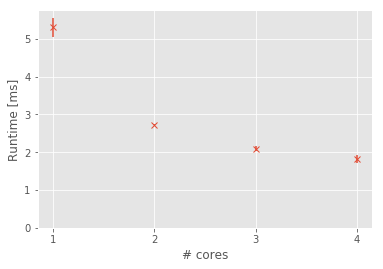

In [6]:
(timings_mean, timings_stdev) = sq_matr_mult_timings(5000, range(1, 5), plot_results=True)

As you can see, the runtime did not decrease linearly with the number of available cores but there are definitely benefits from using more than one CPU core.

Let's try that again but this time with a *much* smaller problem size.

Thread count: 1 -> 7.33 µs ± 87.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Thread count: 2 -> 6.59 µs ± 62.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Thread count: 3 -> 6.29 µs ± 54.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Thread count: 4 -> 5.8 µs ± 61.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


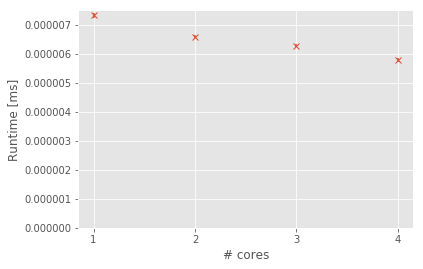

In [7]:
(timings_mean, timings_stdev) = sq_matr_mult_timings(50, range(1, 5), plot_results=True)

Here the scaling with CPU cores is much poorer.

You'd like to hope that as you distribute work between more threads that there will be a linear decrease in execution time.  However, that's not always the case:

 - If there are more threads than cores then threads will have to take it in turns to run;
 - For a given matrix size: as the number of threads grows at some point the cost of setup, tear-down and inter-thread communication/synchronisation may become significant.  This is what is happening with the smaller problem size above.  As we increase the problem size above that of the first example we  than the first example then we should asymptotically converge on linear scaling.
 - It is useful to consider [Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law) when assessing how well a problem will scale with more parallelisation: this law broadly states that speedup of parallelising some code is a limited by the proportion that runs in series.  Assessing just how much code runs in series is difficult in this particular case as some code is in this Notebook, some is in the numpy package and some is in the MKL. In other situations it may be much easier for you to identify the sections of code that do (must?) execute in series and therefore limit the maximum speedup achievable by parallelisation:
 
<img src="../static/parallel_code_with_serial_sections.svg" alt="Parallel code with serial sections" height="300px"
    width="200px" />

## How many cores do we need? 

This isn't an easy question to answer and depends on the problem size and on the algorithm and code used to solve the problem.  On 'single-tenant' machines such as your own laptop it is therefore often best to just let the MKL decide on an appropriate number of threads.  This is what it does by default; we've only explicitly set the thread count here to demonstrate the effects of multithreading on performance.

On 'multi-tenant' systems such as HPC clusters like ShARC one typically needs to request the number of cores required at the start of the job then within the job there may be hundreds or possibly millions of multi-threadable linear algebra operations (or other multi-threadable operations if using something other than the MKL behind the scenes).   How many cores should one request of the Distributed Resource Manager that controls the cluster when you first submit/start your job?  Well, if you think you might benefit from multithreading and are using a library that supports it then try running some short tests with what you believe are the worst-case problem sizes within your job and, as above, capturing execution times for different thread/core counts to see how your problem scales with CPU cores.    

## Restricting the MKL to running on a subset of the available cores

When might we want to do this?  Well, one reason might be that we are wanting to execute multiple strands of our workflow and each involves linear algebra operations.  For optimal performance we might therefore want to run

* $n$ Python processes on $n$ cores, each of which 
* runs linear algebra functions using $1$ thread.

If each of the $n$ processes used $1<m<=n$ threads for the linear algebra functions then then there would be contention between the $n \cdot m$ threads for CPU time and we would not see any benefit to using multiple threads with the MKL. 

## A note on physical vs virtual processing cores (hyperthreading)

 Be aware that on the majority of modern Intel processors that each physical CPU core typically provides two *virtual cores* aka *hardware threads* using a technology called [Hyper-Threading](https://en.wikipedia.org/wiki/Hyper-threading). 
 
 
These virtual cores provide greater parallelism for workloads that are primarily IO (input/output) such as networking, running databases or interactive desktop/laptop usage.  However, you do not want to distribute floating-point calculations between both virtual cores of a physical core as the virtual cores share part of the physical core that handles floating-point calculations (the Floating Point Unit (FPU)).  Contention between virtual cores for the FPU can result in numerical workloads running slower with than if hyperthreading were disabled.  For this reason hyperthreading is disabled on all nodes in ShARC (bar a small number dedicated for CPU usage).  

You can check to see if hyperthreading is enabled using a program called `lstopo`, which shows the internal architecture of a machine.  Here's graphical output from `lstopo` for a Dell XPS 9550 laptop.  This shows that each of the four physical cores is comprised of two virtual cores i.e. hyperthreading is enabled. 
 
<img src="../static/dell-xps-9550-lstopo-cpu-ram.svg" alt="Parallel code with serial sections" width="30%"/>
 
Here's graphical output from running `lstopo` on ShARC within a 16-core job on a 16-core node where hyperthreading is disabled.  
 
<img src="../static/sharc-node005-lstopo-cpu-ram.svg" alt="Parallel code with serial sections" width="60%"/>

Run the following cell to see the architecture of the machine running this Jupyter Notebook.  *Note: if you run `lstopo` on the ShARC or Iceberg clusters you'll only see information on the CPU cores that have been allocated to your job*.

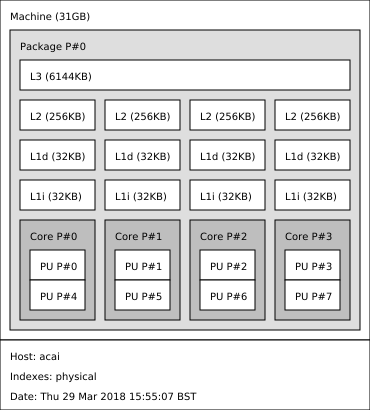

In [14]:
tmp = os.path.join(os.sep, 
                   os.environ['TMPDIR'] if 'TMPDIR' in os.environ else 'tmp',
                   str(os.getpid()))
import subprocess
subprocess.check_output(['lstopo', '--no-io', '--no-bridges', '--output-format', 'svg', '-f', tmp])
with open(tmp, 'r') as svg_file:
    svg = svg_file.read()
SVG(svg)

## So what else can use the MKL for multithreaded linear algebra?

A variety of Python packages distributed using conda can use the MKL for multithreaded linear algebra, either by depending on numpy to talk to the MKL or by using the MKL directly.  

The scipy package, for example, can use the MKL to accelerate more involved operations such as [singular value decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) (a means for factorising a real- or complex-valued matrix):

In [ ]:
z = np.random.random_sample((1500, 500))

thread_cnts = np.arange(1, 5)
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    mkl.set_num_threads(i)
    print("Thread count: {}".format(i), end=" -> ")
    timings = %timeit -n 5 -o scipy.linalg.svd(z)
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

Again, speedup is far from linear with the number of cores but there is value in using multiple cores with this size of problem.   

Above, we discussed how we don't benefit from having more threads than cores (at least for numerical problems).  Here we demonstrate that we get no further benefit from increasing the number of threads beyond the number of available CPU cores:     

In [ ]:
z = np.random.random_sample((1500, 500))

thread_cnts = np.power(2, range(6))
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    print("Thread count: {}".format(i), end=" -> ")
    mkl.set_num_threads(i)
    timings = %timeit -n1 -o scipy.linalg.svd(z)
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

As you can see, in this case we actually get a performance regression when we go beyond the number of cores available in the machine. 

## Accelerating FFTs using pyfftw and multiple threads

As we've seen, numpy can use the Intel MKL for multi-threaded linear algebra operations. 
The MKL also includes [fast Fourier transform][fft-wikipedia] (FFT) functions
that can also use multiple threads and therefore multiple cores for distributing work.  
However, although the numpy FFT functions can use the MKL for FFT calculations 
the MKL is not called in a way that allows multiple threads to be used efficiently 
(see [this blog post][numpy-mkl-fft-blog]).

Let's use this an opportunity to explore how a different Python package, [pyfftw][pyfftw], uses a different compiled library, [FFTW][fftw], to provide efficient multithreaded FFT functions.  FFTW is a very widely used and mature FFT library that can calculate 1D, 2D and 3D forward and inverse FFTs. 

Note: here we use pyfftw's native and most efficient way of calculating FFTs, which involves preallocating input and output arrays then generating then evaluating a execution plan.  If you want a more concise way of using pyfftw that presents an interface that very closely mirrors the FFT-related parts of the numpy API then see `pyfftw.interfaces.numpy_fft.fft` and/or `pyfftw.builders.fft`.

[fft-wikipedia]: (https://en.wikipedia.org/wiki/Fast_Fourier_transform)
[numpy-mkl-fft-blog]: http://rse.shef.ac.uk/blog/numpy-mkl-fft/
[pyfftw]: https://hgomersall.github.io/pyFFTW/
[fftw]: http://fftw.org

In [ ]:
# Size of 3D FFT input
size = (1024, 1024, 128)

# Preallocate a 2GB array of complex values for storing randomly generated input data.
# This preallocation allows the array to be 'aligned' in memory in a way that offers 
# best performance on hardware with SIMD support (e.g. with AVX support; see mention of SIMD in the next section)
a = pyfftw.empty_aligned(size, dtype='complex128')
out = pyfftw.empty_aligned(size, dtype='complex128')

# Randomly generate the real and imaginary components of our 3D FFT input
a[:] = np.random.randn(*size) + (1j * np.random.randn(*size))

In [ ]:
# To store timings for the FFT calculations
timings_mean = []
timings_stdev = []

# Range of thread counts for which to measure performance
thread_cnts = np.arange(1, 5)

for i in thread_cnts:
    # Constructs a plan for how to calculate the FFT efficiently given the input data type and size 
    # Note that we're not timing this setup function
    fft_plan = pyfftw.FFTW(a, out, threads=i) 
    
    # Time the FFT calculation
    timings = %timeit -o fft_plan.execute()

    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)
    
# Plot the results
fig, ax = plt.subplots()
ax.errorbar(thread_cnts, timings_mean, yerr=timings_stdev, fmt='x')
ax.set_xticks(thread_cnts)
ax.set_xticklabels(thread_cnts)
ax.set_xlabel('# cores')
ax.set_ylabel('Runtime [ms]');
ax.set_ylim(ymin=0);

# Free memory
del a, out

Note that for this 3D 2GiB matrix of complex values the forward FFT scaling doesn't improve much beyond a couple of cores.

**TODO**: WHY IS THIS?  If you re-run the above two cells after setting `size` in the first cell so that 

```
size = (1024 * 1024 * 128, )
```

so as to use 1D inputs and outputs then there's a bit better scaling as you move from 2 to 3 cores.

## Using the MKL on CPUs that can accelerate certain operations 

Another easy win when it comes to performance is making sure that you use the MKL on CPU(s) that have:

* Support for atomically applying the same operation to vectors of values ('Single Instruction Multiple Data' (SIMD) hardware vectorisation) using some flavour of Intel's [Advanced Vector Extensions][avx] (AVX). 
* Support for atomically multiplying two values and adding them to an 'accumulator' CPU [register][cpu-reg] (storage location on the CPU).  This CPU instruction, known as [fused multiply-add][fma] (FMA), can help speed up matrix multiplication as that operation consists entirely of sums of multiplications.  

You can get additional performance out of many libraries, not just the MKL, if they are able to use AVX and/or FMA.  With AVX this typically requires that software is written and compiled so that it is AVX-aware but the MKL is able to just detect and use AVX and FMA at execution time, making life much easier for the numpy user.  

The CPUs in the ShARC cluster at the University of Sheffield have both AVX2 and FMA support. You can check if you have AVX and/or FMA support using the [cpuinfo][cpuinfo] Python package:

[avx]: https://en.wikipedia.org/wiki/Advanced_Vector_Extensions
[cpu-reg]: https://en.wikipedia.org/wiki/Processor_register
[fma]: https://en.wikipedia.org/wiki/Multiply%E2%80%93accumulate_operation#Fused_multiply%E2%80%93add
[cpuinfo]: https://github.com/workhorsy/py-cpuinfo

In [ ]:
cpu_features = cpuinfo.get_cpu_info()['flags']
set(cpu_features).intersection(set(('fma', 'avx', 'avx2', 'avx512')))

or from the command-line:

In [ ]:
!grep -oE '\W(fma|avx|avx2)\W' /proc/cpuinfo | sort | uniq

*Jupyter Tip: if a line in a code cell starts with `!` then the rest of the line is run in a shell, not executed as Python code.*

# MOVE ELSEWHERE

**TODO**: Useful for looking at effect of oversubscription and for parameterising thread ranges?  Only if output is limited by cgroups/cpusets - NO! TODO: check on ShARC.  Todo: explain hardware threads, hyperthreading, physical cores per socket, sockets, numactl

In [ ]:
def get_phys_cores():
    hardware_threads = cpuinfo.get_cpu_info()['count'] 
    if 'ht' in cpuinfo.get_cpu_info()['flags']:
        cores = int(hardware_threads / 2)
    else:
        cores = hardware_threads
    return cores

phys_cores = get_phys_cores()
phys_cores

In [ ]:
%%bash 
hardware_threads=$(grep -Ec '^processor\W' /proc/cpuinfo)
if grep -Eq '^flags.*\Wht\W' /proc/cpuinfo; then
    phys_cores=$((hardware_threads / 2))
else
    phys_cores=$hardware_threads
fi
echo $hardware_threads, $phys_cores

In [ ]:
%%bash
# Shows all hardware threads, not physical cores
taskset -pac $$

In [ ]:

# Show just physical cores (restricted by cgroup!)
import subprocess
subprocess.check_output('lstopo --only cores'.split()).split(os.sep)

#avail_phys_cores = int((!lstopo --only cores | wc -l) 
#avail_phys_cores

In [ ]:
%%bash
# Show hardware threads (restricted by cgroup!)
lstopo --only pu